# 2D heat conduction

The equation of heat conduction in 2D is:

$$
\begin{equation}
\rho c_p \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left( \kappa_x \frac{\partial T}{\partial x} \right) + \frac{\partial}{\partial y} \left(\kappa_y \frac{\partial T}{\partial y} \right)
\end{equation}
$$

where $\rho$ is the density, $c_p$ is the heat capacity and $\kappa$ is the thermal conductivity.

If the thermal conductivity $\kappa$ is constant, then we can take it outside of the spatial derivative and the equation simplifies to:

$$
\begin{equation}
\frac{\partial T}{\partial t} = \alpha \left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} \right)
\end{equation}
$$

where $\alpha = \frac{\kappa}{\rho c_p}$ is the thermal diffusivity.  The thermal diffusivity describes the ability of a material to conduct heat vs. storing it.



Let's write this out discretized using forward difference in time, and central difference in space,  using an explicit scheme. You should be able write this out yourself, without looking—if you need to look, it means you still need to write more difference equations by your own hand!

$$
\begin{equation}
\frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} = \alpha \left( \frac{T^n_{i+1, j} - 2T^n_{i,j} + T^n_{i-1,j}}{\Delta x^2} + \frac{T^n_{i, j+1} - 2T^n_{i,j} + T^n_{i,j-1}}{\Delta y^2}\right)
\end{equation}
$$
suppose we have 
$$
\begin{equation}
{\Delta x^2}={\Delta y^2}
\end{equation}
$$
Now our discrtized equation will simpler 



$$
\begin{equation}
\frac{T^{n+1}_{i,j} - T^n_{i,j}}{\Delta t} =  \alpha( \frac{T^n_{i+1, j} - 4T^n_{i,j} + T^n_{i-1,j} + T^n_{i, j+1} + T^n_{i,j-1}} {\Delta x^2})
\end{equation}
$$
Rearranging the equation to solve for the value at the next time step, $T^{n+1}_{i,j}$, yields

$$
\begin{equation}
T^{n+1}_{i,j}= T^n_{i,j} + \alpha \left( \frac{\Delta t}{\Delta x^2} (T^n_{i+1, j} - 2T^n_{i,j} + T^n_{i-1,j}) + \\\frac{\Delta t}{\Delta y^2} (T^n_{i, j+1} - 2T^n_{i,j} + T^n_{i,j-1})\right) = T^n_{i,j} + \frac{\Delta t}{\Delta x^2}\alpha (T^n_{i+1, j} - 4T^n_{i,j} + T^n_{i-1,j} + T^n_{i, j+1} + T^n_{i,j-1})
\end{equation}
$$

### Stability analysis

Before doing any coding, let's revisit stability constraints. We saw in the 1D explicit discretization of the diffusion equation was stable as long as $\alpha \frac{\Delta t}{(\Delta x)^2} \leq \frac{1}{2}$. In 2D, this constraint is even tighter, as we need to add them in both directions:

$$
\begin{equation}
\alpha \frac{\Delta t}{(\Delta x)^2} + \alpha \frac{\Delta t}{(\Delta y)^2} < \frac{1}{2}.
\end{equation}
$$

Say that the mesh has the same spacing in $x$ and $y$, $\Delta x = \Delta y = \delta$. In that case, the stability condition is:

$$
\begin{equation}
\alpha \frac{\Delta t}{\delta^2} < \frac{1}{4}
\end{equation}
$$

### Problem statement

We understand how heat is conducted through water . we consider 2D water body of size $1{\rm m}\times 1{\rm m}$, with a thermal diffusivity $\alpha \approx 0.146.10^{-6}{\rm m}^2{/\rm s}$. 
We're going to set up a somewhat artificial problem, just to demonstrate an interesting numerical solution. water is in contact at left side with a heat source which has a constant temperature of $T=100°C $, and for the rest of the edges it is in contact with insulating material, Initially, the water temperature is at $(25{\rm C})$. *How long does it take for the water tempreture to be fully warmed by the heat source ?*

### Boundary Conditions

Whenever we reach a point that interacts with the boundary, we apply the boundary condition,if the boundary has Dirichlet conditions, we simply impose the prescribed temperature $T=100°C $ at $y=0$ at the left side. If the boundary has Neumann conditions, we approximate them with a finite-difference scheme.

Remember, Neumann boundary conditions prescribe the derivative in the normal direction. For example, in the problem described above, we have $\frac{\partial T}{\partial y} = q_y$ in the top boundary and $\frac{\partial T}{\partial x} = q_x$ in the right boundary, with $q_y = q_x = 0$ (insulation).

Thus, at every time step, we need to enforce

$$
\begin{equation}
T_{i,end} = q_y\cdot\Delta y + T_{i,end-1}
\end{equation}
$$

and

$$
\begin{equation}
T_{end,j} = q_x\cdot\Delta x + T_{end-1,j}
\end{equation}
$$

In [1]:
from mpl_toolkits import mplot3d
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt 
from IPython.display import HTML
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

In [43]:
Lx = 1  # length of the plate in the x direction
Ly = 1  # height of the plate in the y direction
nx = 41  # number of points in the x direction
ny = 41  # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction
alpha = 0.146e-6 # thermal diffusivity of the water

# Define the locations along a gridline.
x = np.linspace(0.0, Lx, num=nx)
y = np.linspace(0.0, Ly, num=ny)

# Compute the initial temperature distribution.
Tb = 100.0  # temperature at the left boundaries
T0 = 25.0 * np.ones((ny, nx))
#apply Dirichlet boundary conditions
T0[:, 0] = Tb #here T[j,i] because in python j represnts the rows which corresponds to y axis  and i represnts the colums which corresponds to x axis


In [44]:
sigma = 0.24
dt = (sigma * dx**2 )/ alpha  # time-step size
nt = 100
c=(dt*alpha)/dx**2

In [45]:
T=T0.copy()
for i in range (nt):
    Tn=T.copy()
    T[1:-1, 1:-1] = (Tn[1:-1, 1:-1] +
                     c * (Tn[1:-1, 2:] - 4.0 * Tn[1:-1, 1:-1] + Tn[1:-1, :-2] 
                    + Tn[2:, 1:-1] + Tn[:-2, 1:-1]))
#apply Neumann boundary conditions                     
    T[-1,:]=T[-2,:]                     
    T[:, -1] = T[:, -2]   
    T[0,:] = T[1,:]                               

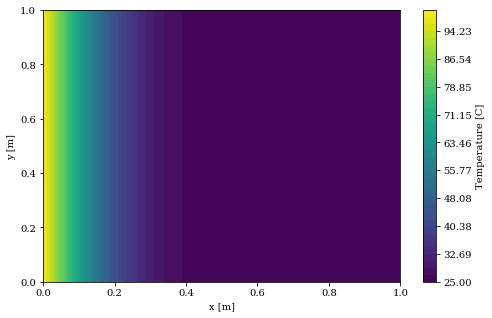

In [46]:
# Plot the filled 2d contour of the temperature.
plt.figure(figsize=(8.0, 5.0))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
levels= np.linspace(25.0, 100.0, num=40)
contf = plt.contourf(x, y, T, levels=levels)
cbar = plt.colorbar(contf)
cbar.set_label('Temperature [C]')

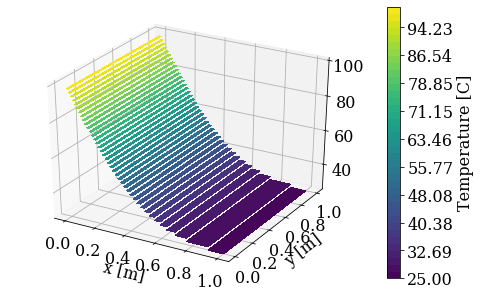

In [7]:
# Plot the filled 3d contour of the temperature.
plt.figure(figsize=(8.0, 5.0))
axis=plt.gca(projection= "3d")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
levels= np.linspace(25.0, 100.0, num=40)
contf = plt.contourf(x, y, T, levels=levels)
cbar = plt.colorbar(contf)
cbar.set_label('Temperature [C]')


In [12]:
def ftcs(T0,nt, c):
    T=T0.copy() 
    for i in range (nt):
        Tn=T.copy()
        T[1:-1, 1:-1] = (Tn[1:-1, 1:-1] +
                     c * (Tn[1:-1, 2:] - 4.0 * Tn[1:-1, 1:-1] + Tn[1:-1, :-2] 
                    + Tn[2:, 1:-1] + Tn[:-2, 1:-1]))
#apply Neumann boundary conditions                     
        T[-1,:]=T[-2,:]                     
        T[:, -1] = T[:, -2]   
        T[0,:] = T[1,:]                    
    return T

In [13]:
nt = 1000
c=(dt*alpha)/dx**2
T1=ftcs(T0, nt,c)

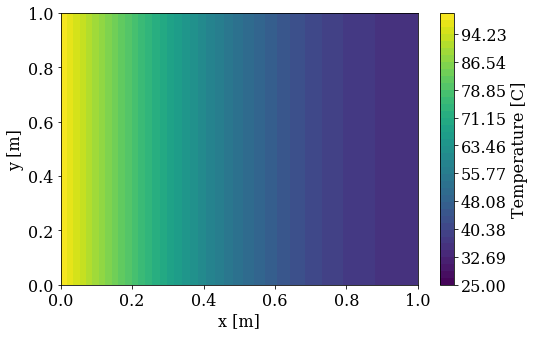

In [14]:
# Plot the filled 2d contour of the temperature.
fig=plt.figure(figsize=(8.0, 5.0))
plt.xlabel('x [m]')
plt.ylabel('y [m]')
levels= np.linspace(25.0, 100.0, num=40)
contf = plt.contourf(x, y, T1, levels=levels)
cbar = plt.colorbar(contf)
cbar.set_label('Temperature [C]')

In [29]:
#def animate(n):
    #fig.suptitle('Time step {:0>2}'.format(n))
    

In [30]:
#anim = animation.FuncAnimation(fig, animate,frames=nt , interval=100)

__3D heat conduction__

Now we are going to expand our problem into 3D , adding a z dimension with the same height , thus we are going to have $1{\rm m}\times 1{\rm m}\times 1{\rm m}$ water with the same initial conditions as before
our new equation will be if 
$$
\begin{equation}
{\Delta x^2}={\Delta y^2}={\Delta z^2}
\end{equation}
$$
$$
\begin{equation}
\frac{T^{n+1}_{i,j,k} - T^n_{i,j,k}}{\Delta t} =  \alpha( \frac{T^n_{i+1, j,k} - 6T^n_{i,j,k} + T^n_{i-1,j,k} + T^n_{i, j+1,k} + T^n_{i,j-1,k}+ T^n_{i, j,k+1} +T^n_{i, j,k-1}}{\Delta x^2})
\end{equation}
$$
Rearranging the equation to solve for the value at the next time step, $T^{n+1}_{i,j}$, yields

$$
\begin{equation}
T^{n+1}_{i,j,k} = T^n_{i,j,k} + \frac{\Delta t}{\Delta x^2}\alpha (T^n_{i+1, j,k} - 6T^n_{i,j,k} + T^n_{i-1,j,k} + T^n_{i, j+1,k} + T^n_{i,j-1,k}+ T^n_{i, j,k+1} +T^n_{i, j,k-1})
\end{equation}
$$

__Stability analysis__

Now let's examine the stability constraint of 3D dimensions

$$
\begin{equation}
\alpha \frac{\Delta t}{(\Delta x)^2} + \alpha \frac{\Delta t}{(\Delta y)^2} + \alpha \frac{\Delta t}{(\Delta z)^2} < \frac{1}{2}.
\end{equation}
$$

Say that the mesh has the same spacing in $x$,$y$,$z$ $\Delta x = \Delta y = \Delta z = \delta $. In that case, the stability condition is:

$$
\begin{equation}
\alpha \frac{\Delta t}{\delta^2} < \frac{1}{6}
\end{equation}
$$

In [2]:
Lx = 1  # length of the plate in the x direction
Ly = 1 # height of the plate in the y direction
Lz = 1 # height of the plate in the z direction
nx = 41  # number of points in the x direction
ny = 41 # number of points in the y direction
nz= 41 # number of points in the z direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1) # grid spacing in the y direction
dz = Lz / (nz - 1) # grid spacing in the z direction
alpha = 0.146e-6 # thermal diffusivity of the water

# Define the locations along a gridline.
x = np.linspace(0.0, Lx, num=nx)
y = np.linspace(0.0, Ly, num=ny)
z = np.linspace(0.0, Lz, num=nz)

#initial conditions
T0=25.0*np.ones((nx,ny,nz))
Tb=100.0
T0[:,0,:]= Tb
 

In [3]:
sigma = 0.16
dt = (sigma * dx**2 )/ alpha  # time-step size
nt = 500
c=(dt*alpha)/dx**2

In [4]:
%%time
T=T0.copy()
for i in range (nt):
        Tn=T.copy()
        T[1:-1, 1:-1,1:-1] = (Tn[1:-1, 1:-1,1:-1] + c * (Tn[1:-1, 2:,1:-1] - 6.0 * Tn[1:-1, 1:-1,1:-1] 
                                                         + Tn[1:-1, :-2,1:-1] + + Tn[2:, 1:-1,1:-1] + Tn[:-2, 1:-1,1:-1]+ Tn[1:-1,1:-1,2:] 
                                                         + Tn[ 1:-1,1:-1,:-2] ))
                                                         
       
      #apply Neumann boundary conditions                     
        T[-1,:,:]=T[-2,:,:]   #delta t/ delta y = 0 at y=ly                    
        T[:, -1,:] = T[:, -2,:] #delta t/ delta x = 0 at x=lx    
        T[0,:,:] = T[1,:,:] #delta t/ delta y = 0 at y=0  
        T[:,:,-1] = T[:,:,-2] #delta t/ delta z = 0 at z=Lz 
        T[:,:,0] = T[:,:,1] #delta t/ delta z = 0 at z=0     

Wall time: 1.1 s


In [5]:
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with ipy backend.


In [92]:
X,Y,Z=np.mgrid[0:1:41j,0:1:41j,0:1:41j]

In [19]:
mlab.clf()
s=mlab.volume_slice(T,plane_orientation='z_axes')
mlab.title('time step is {}' .format(nt))
mlab.colorbar(object=None, title='Temperature',orientation='horizontal')
s                                           

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…